In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
# from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy

from tqdm import tqdm

from isingCA import isingCA
import pygame

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.1.2 (SDL 2.0.18, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, :, i, j] = 1.
    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, :, i, j] = -1.
    return state

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), CHANNELS)
    
    return cdim_order
    
def WHEEL_beta(beta, direction):
    
    return beta + direction * 0.01

In [3]:
def print_beta(beta):
    fps = f'{beta:.3f}'
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf

# Test

In [4]:
CHANNELS=1 # number of channels in grid
RADIUS=1
BETA=1/(RADIUS * RADIUS * CHANNELS)
ca = isingCA(CHANNELS=CHANNELS, BETA=BETA, RADIUS=RADIUS).cuda() 

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(-0.5, 2.5, 2.5, -0.5)

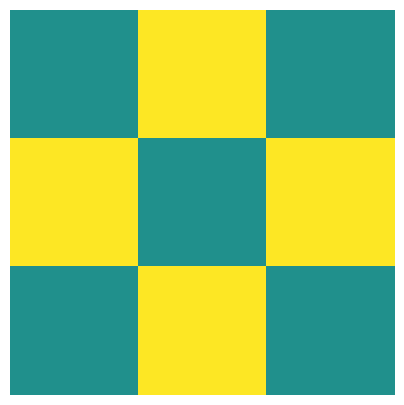

In [5]:
kernels = torch.cat([k for k in ca.rule.nearest_neighbours], dim=0).cpu().detach().numpy()
# kernels = totalistic(ca.rule.kernels[0].cpu().detach()).numpy()

num_plot_kernels = np.min([6, CHANNELS])
fig, axes = plt.subplots(1, num_plot_kernels, figsize=(5, 5))

kplot = kernels[0, :, :]
kmax = np.max(np.abs(kplot))
axes.imshow(kplot, vmin=-kmax, vmax=kmax)
axes.axis('off')

# for j in range(num_plot_kernels):
#     kplot = kernels[j, :, :]
#     kmax = np.max(np.abs(kplot))
#     axes[j].imshow(kplot, vmin=-kmax, vmax=kmax)
#     axes[j].axis('off')

In [6]:
# brush properties
r = 20
s = 1

In [7]:
# resolution of grid
RESX=1280
RESY=720

# pygame stuff
######################################
pygame.init()
size = RESX, RESY
# screen = pygame.display.set_mode(size)
screen = pygame.Surface(size)
UPSCALE = 1
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

running = True
time_ticking = True
self_organize = False
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, CHANNELS)
beta = BETA

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################

# CENTER SEED
# seed = torch.cuda.FloatTensor(np.zeros((CHANNELS, RESX, RESY))).unsqueeze(0)
# seed[:, 3:, RESX//2, RESY//2] = 1
# state = seed.clone()

state = ca.initGrid((RESX, RESY))

# inject noise
signal_injection = torch.zeros(size=state.shape)
noise_amp = 1.
noise_idx = slice(4, 10)

update_rate = 1.
ticker = 0.
sink = False
export_imgs = False
imgs = []

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = event.y
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_LEFTBRACKET:
                update_rate += -0.5
            if event.type== pygame.KEYDOWN and event.key == pygame.K_RIGHTBRACKET:
                update_rate += 0.5
            
            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1])
                    
            if event.type == pygame.KEYDOWN and event.key == pygame.K_o:
                self_organize = not self_organize
        
            if event.type == pygame.KEYDOWN and event.key == pygame.K_s:
                sink = not sink
            if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type == pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = ca.initGrid((RESX, RESY))
                ca.rule.beta = 2.
                

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)
        
        
        if WHEEL_trigger:
            ca.rule.beta = WHEEL_beta(ca.rule.beta, direction)
            WHEEL_trigger = False
            
#         nx = state.cpu()[:, cdim_order].numpy()[0, 0, :, :].transpose(1, 2, 0)
        if CHANNELS == 1:
            nx = state.cpu().numpy()[0, 0, :, :]
        else:
            nx = state.cpu().numpy()[0, 0:3, :, :].transpose(1, 2, 0)
        nx = (nx + 1) / 2 * 255

        if time_ticking:
            state = ca.forward(state)
            ticker += 1
    
        if sink and time_ticking:
            xv, yv = torch.linspace(-1, 1, RESX), torch.linspace(-RESY/RESX, RESY/RESX, RESY)
            X, Y = torch.meshgrid(xv, yv)
            amp = 0.00
            w = 30
            R = torch.sqrt(X**2 + Y**2).cuda()
            state = torch.where(R > 0.5, -torch.ones_like(state).cuda(), state)

        if export_imgs and time_ticking:
            imgs.append(nx)
        
        if self_organize and ticker % 3 == 0:
            sm = state.mean().abs().cpu().detach().numpy()
            
            alpha = 1e-1 # update rate
            h = 1 # magnetization coef
            eps = 1e-3 # temp decay coef
            
            T = 1 / (ca.rule.beta + 1e-6)
#             dT = (h * sm**2 - eps * T)
            dT = h * sm**2 - eps
            T += alpha * dT
            ca.rule.beta = 1 / (T + 1e-6)
#             if sm > 1e-4: # if Mag is larger than 0, increase temperature
#                 ca.rule.beta *= 1 - np.min([sm, 0.1])
#             elif sm < 1e-5: # if Mag is too close to 0, decrease temperature
#                 ca.rule.beta *= 1. + np.min([sm, 0.1])

        pygame.surfarray.blit_array(screen, nx)        
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        upscaled_screen.blit(print_beta(1 / ca.rule.beta), (10,20))
        pygame.display.flip()
        clock.tick(240)
        
pygame.quit()


In [8]:
fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RESX, RESY), 3)
out = cv2.VideoWriter(f'videos/CA-{fname}.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 60, (RESX, RESY), 1)


for img in imgs:
#     img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)).transpose(1, 0, 2)
    out.write(img)
out.release()

(array([466327.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 455273.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

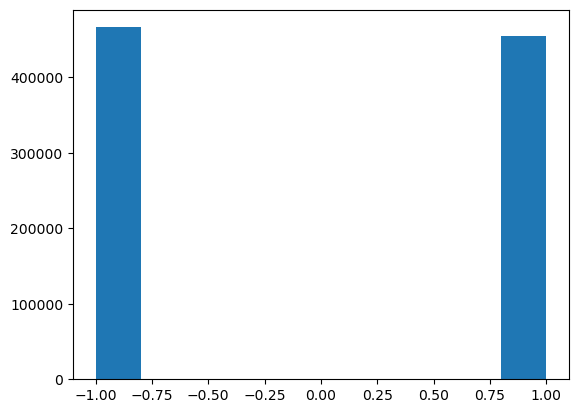

In [9]:
plt.hist(state.reshape(-1).cpu().detach().numpy())